In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from prophet.diagnostics import performance_metrics
from prophet import Prophet

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
D003_df = pd.read_csv('./../../../../../Data/SensorsData/interpolated_D003_data.csv')
D003_df
D003_df['time'] =  pd.to_datetime(D003_df['time'], format='%Y-%m-%d %H:%M:%S')
D003_df.rename(columns = {'Rn':'y','time':'ds'}, inplace = True)
D003_df = D003_df.reset_index(drop=True)
D003_df
# D001_df.index = D001_df['time']
# D001_df = D001_df.drop(['time'],axis = 1)
# D001_df.index = D001_df.index.rename('ds')
# D001_df.rename(columns = {'Rn':'y'}, inplace = True)
# D001_columns = list(D001_df.columns)
# D001_columns[0],D001_columns[1] = D001_columns[1],D001_columns[0]
# D001_df = D001_df[D001_columns]

,ds,T,y,H,P,CO2
0,2019-07-09 17:00:00,33.463333,0.100000,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,33.490000,0.150000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,33.180000,0.161667,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,33.315000,3.451667,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,32.846667,11.556667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [21]:
D003_df

,ds,T,y,H,P,CO2
0,2019-07-09 17:00:00,33.463333,0.100000,38.000000,101.363333,39.666667
1,2019-07-09 18:00:00,33.490000,0.150000,37.666667,101.333800,50.500000
2,2019-07-09 19:00:00,33.180000,0.161667,39.333333,101.331833,50.666667
3,2019-07-09 20:00:00,33.315000,3.451667,40.666667,101.340333,53.833333
4,2019-07-09 21:00:00,32.846667,11.556667,41.333333,101.389333,53.000000
...,...,...,...,...,...,...
20019,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
20020,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
20021,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
20022,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [22]:
training_data, testing_data = train_test_split(D003_df, test_size=0.2, shuffle=False)
testing_data = testing_data.reset_index(drop=True)

testing_data_v2 = testing_data[['ds','T','H','P','CO2']]
testing_data_v2 = testing_data.reset_index(drop=True)


print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 16019
No. of testing examples: 4005


In [23]:
testing_data_v2

,ds,T,y,H,P,CO2
0,2021-07-15 09:00:00,34.195000,477.975000,26.500000,101.388667,47.500000
1,2021-07-15 10:00:00,34.661667,451.705000,25.833333,101.374667,47.166667
2,2021-07-15 11:00:00,34.713333,443.681667,25.666667,101.360500,49.333333
3,2021-07-15 12:00:00,35.198000,452.508000,26.600000,101.333000,51.600000
4,2021-07-15 13:00:00,35.420000,354.636000,25.200000,101.298000,48.200000
...,...,...,...,...,...,...
4000,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
4001,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
4002,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
4003,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [24]:
model = Prophet()
model.add_regressor('T',standardize = False)
model.add_regressor('H',standardize = False)
model.add_regressor('P',standardize = False)
model.add_regressor('CO2',standardize = False)

In [25]:
model.fit(training_data)

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [26]:
forecast = model.predict(testing_data_v2)
forecast = forecast[['ds','yhat']]

C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\valdo\anaconda3\envs\RnHealth\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [27]:
testing_data

,ds,T,y,H,P,CO2
0,2021-07-15 09:00:00,34.195000,477.975000,26.500000,101.388667,47.500000
1,2021-07-15 10:00:00,34.661667,451.705000,25.833333,101.374667,47.166667
2,2021-07-15 11:00:00,34.713333,443.681667,25.666667,101.360500,49.333333
3,2021-07-15 12:00:00,35.198000,452.508000,26.600000,101.333000,51.600000
4,2021-07-15 13:00:00,35.420000,354.636000,25.200000,101.298000,48.200000
...,...,...,...,...,...,...
4000,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
4001,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
4002,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
4003,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


In [28]:
forecast

,ds,yhat
0,2021-07-15 09:00:00,37.460686
1,2021-07-15 10:00:00,-23.873802
2,2021-07-15 11:00:00,-59.126446
3,2021-07-15 12:00:00,-49.969276
4,2021-07-15 13:00:00,-54.939194
...,...,...
4000,2021-12-31 19:00:00,129.170531
4001,2021-12-31 20:00:00,187.911530
4002,2021-12-31 21:00:00,209.255907
4003,2021-12-31 22:00:00,207.909115


In [29]:
comparation_df = pd.concat((pd.DataFrame(forecast['yhat']),testing_data),axis = 1)

In [30]:
comparation_df 

,yhat,ds,T,y,H,P,CO2
0,37.460686,2021-07-15 09:00:00,34.195000,477.975000,26.500000,101.388667,47.500000
1,-23.873802,2021-07-15 10:00:00,34.661667,451.705000,25.833333,101.374667,47.166667
2,-59.126446,2021-07-15 11:00:00,34.713333,443.681667,25.666667,101.360500,49.333333
3,-49.969276,2021-07-15 12:00:00,35.198000,452.508000,26.600000,101.333000,51.600000
4,-54.939194,2021-07-15 13:00:00,35.420000,354.636000,25.200000,101.298000,48.200000
...,...,...,...,...,...,...,...
4000,129.170531,2021-12-31 19:00:00,28.650000,956.366667,35.833333,102.174500,43.833333
4001,187.911530,2021-12-31 20:00:00,28.758000,1275.534000,35.800000,102.192000,41.400000
4002,209.255907,2021-12-31 21:00:00,28.730000,1321.585000,35.000000,102.246667,40.833333
4003,207.909115,2021-12-31 22:00:00,28.530000,1163.278333,34.666667,102.356667,40.166667


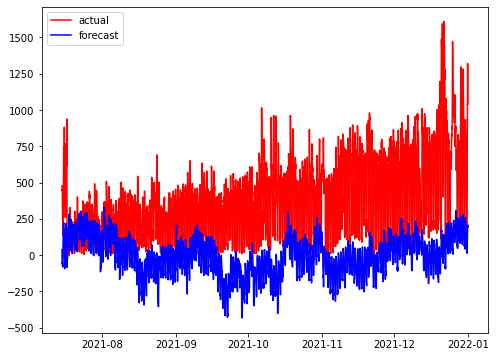

In [13]:
plt.figure(figsize=(8,6))
plt.plot(comparation_df['ds'],comparation_df['y'],color = 'red',label = 'actual')
plt.plot(comparation_df['ds'],comparation_df['yhat'],color = 'blue',label = 'forecast')
plt.legend()